Library imports

In [1]:
import tensorflow as tf
from keras import layers
from keras.datasets import mnist
from keras.layers import Dropout
from tensorflow import keras

import matplotlib.pyplot as plt

2022-04-09 22:01:56.383633: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-09 22:01:56.383660: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Dir for images datasets

In [2]:
import os, shutil, pathlib

original_dir = pathlib.Path("../dataset/intel_images")
new_base_dir = pathlib.Path("../dataset/intel_images_small")

Image Augmentation 

In [3]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

2022-04-09 22:02:13.420516: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-09 22:02:13.420562: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-09 22:02:13.420594: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (linux): /proc/driver/nvidia/version does not exist
2022-04-09 22:02:13.445998: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1.0 / 255)(x)
x = layers.Conv2D(32, 5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = layers.Conv2D(size, 1, strides=2, padding='same', use_bias=False)(residual)
    x = layers.Add()([x, residual])


x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation="softmax")(x)
model = keras.Model(inputs, outputs)



In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 146, 146, 32  2400        ['rescaling[0][0]']          

In [7]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
    )

In [8]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="../models/checkpoints/intel_image_clf_depthwise.keras",
        save_best_only=True,
        monitor='val_accuracy'
    )
]

### Prepare images for training

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    directory=new_base_dir / "train",
    image_size=(150, 150),
    batch_size=32
)
validation_dataset = image_dataset_from_directory(
    directory=new_base_dir / "valid",
    image_size=(150, 150),
    batch_size=32
)
test_dataset = image_dataset_from_directory(
    directory=new_base_dir / "test",
    image_size=(150, 150),
    batch_size=32
)

Found 6000 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [10]:
for data_batch, labels_batch in train_dataset:
    print("Data batch shape: ", data_batch.shape)

    print("Labels batch shape: ", labels_batch.shape)
    break

Data batch shape:  (32, 150, 150, 3)
Labels batch shape:  (32,)


Training the model

In [11]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/10
188/188 [==============================] - 516s 3s/step - loss: 1.1130 - accuracy: 0.5540 - val_loss: 2.0040 - val_accuracy: 0.2257
Epoch 2/10
188/188 [==============================] - 517s 3s/step - loss: 0.8638 - accuracy: 0.6668 - val_loss: 1.6767 - val_accuracy: 0.3537
Epoch 3/10
188/188 [==============================] - 513s 3s/step - loss: 0.7395 - accuracy: 0.7255 - val_loss: 0.9986 - val_accuracy: 0.6160
Epoch 4/10
188/188 [==============================] - 514s 3s/step - loss: 0.6745 - accuracy: 0.7572 - val_loss: 1.7058 - val_accuracy: 0.5043
Epoch 5/10
188/188 [==============================] - 518s 3s/step - loss: 0.6096 - accuracy: 0.7827 - val_loss: 1.7205 - val_accuracy: 0.4910
Epoch 6/10
188/188 [==============================] - 515s 3s/step - loss: 0.5773 - accuracy: 0.7922 - val_loss: 0.7176 - val_accuracy: 0.7437
Epoch 7/10
188/188 [==============================] - 513s 3s/step - loss: 0.5639 - accuracy: 0.7985 - val_loss: 1.1966 - val_accuracy: 0.6487

In [14]:
test_model = keras.models.load_model("../models/checkpoints/intel_image_clf_depthwise.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss},Test Accuracy: {test_acc}")

94/94 [==============================] - 51s 534ms/step - loss: 0.7937 - accuracy: 0.7510
Test Loss: 0.7936608791351318,Test Accuracy: 0.7509999871253967


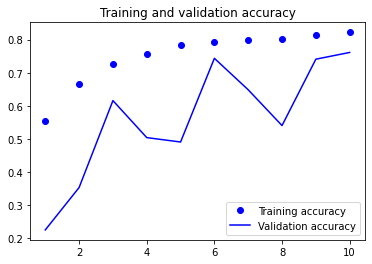

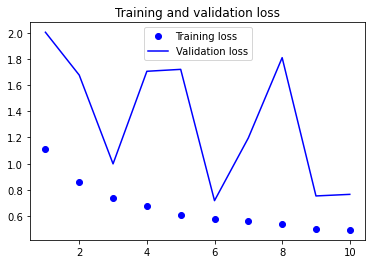

In [12]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()